In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
import numpy as np
import random
import skimage
from skimage import color, exposure
from skimage.feature import hog
import os
import glob


In [2]:
############ Loading Data ###############

from load import *

plt.rcParams['figure.figsize'] = (16, 16)

files = []
for i in range(1,4):
    for j in range(1,5):
        prefix = '/Users/niranjaniprasad/Dropbox/Desktop/COS598C/amg/AMG%d_exp%d'%(i,j)
        files.append( (prefix+'.tif', prefix+'.zip') )

#for f in glob.glob('/Users/niranjaniprasad/Dropbox/Desktop/COS598C/amg/AMG*.tif'):
#    prefix = os.path.splitext(f)[0]
#    files.append( (prefix+'.tif', prefix+'.zip') )
    
data = []
for i,(s,r) in enumerate(files):
    if i==8: data.append((load_stack(s), load_rois(r, 512, 512, xdisp=9, ydisp=-1)))
    else: data.append((load_stack(s), load_rois(r, 512, 512)))

In [3]:
############ Data Processing Functions ###############

def normalizeTile(tile):
    return (tile - tile.mean()) / (tile.std()+0.001)

def getM(stk):
    M = stk.max(axis=0) - stk.std(axis=0)
    M = np.clip((M-900)/400, 0, 1)
    M**=0.5
    return M

def getHogTile(tile):
    fd = hog(normalizeTile(tile), orientations=8, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualise=False)
    return fd

def getHogImg(tile):
    fd, img = hog(normalizeTile(tile), orientations=8, pixels_per_cell=(2, 2), cells_per_block=(1, 1), visualise=True)
    return fd, img

############ Functions for testing ###############

def addNewRoi(i, j, dim, s, out_rois):
    patch = np.zeros((dim, dim))
    patch[i-s:i+s, j-s:j+s] = 1
    for x in range(0, 2*s):
        for y in range(0, 2*s):
            if (s-x)**2 + (s-y)**2 > s*s:
                patch[i-s+x, j-s+y] = 0
    out_rois.append(patch)


In [5]:
############ Training ###############
### Get positive samples ###

ftrain = [0, 1, 2, 3, 4, 5, 6, 7]
ftest = [8, 9, 10, 11]
r = 16

Zfd = []
for i in ftrain:
    stk, rois = data[i]
    M = getM(stk)
    for roi in rois:
        x,y = np.where(roi!=0)
        x,y = int(x.mean()), int(y.mean()) # compute centroid of roi
        if x-r>=0 and y-r>=0 and x+r<512 and y+r<512:
            fd = getHogTile(M[x-r:x+r, y-r:y+r])
            if fd.mean() > 0.005:
                Zfd.append(fd)            
Zfd = np.array(Zfd)

### Get negative samples ###

nZfd = []
for i in ftrain:
    stk, rois = data[i]
    M = getM(stk)
    R = rois.max(axis=0)
    n = 0; print(i)
    while n < 2000:
        x,y = [random.randint(0+r, 512-r),random.randint(0+r, 512-r)]
        if R[x-r:x+r,y-r:y+r].max() == 0:
            fd = getHogTile(M[x-r:x+r, y-r:y+r])
            if fd.mean() > 0.005:
                n = n+1
                nZfd.append(fd) 
nZfd = np.array(nZfd)

### Train SVM ### ~10 mins with 8 stacks

X = np.concatenate([Zfd,nZfd])
Y = np.concatenate([np.ones(len(Zfd)),np.ones(len(nZfd))*0])

svm1 = SVC(kernel="rbf", probability=True)
%time svm1.fit(X,Y) 

del nZfd, Zfd, X, Y

0
1
2
3
4
5
6
7
CPU times: user 8min 31s, sys: 1.22 s, total: 8min 32s
Wall time: 8min 33s


In [ ]:
############ Evaluating SVM1 ###############
### Run SVM prediction ### Slow

(stk, rois) = data[10]

dim = 512
skip = 1
r = 16
M = getM(stk)
YPred = []
for x in xrange(0+r, dim-r, skip):
    for y in xrange(0+r, dim-r, skip):
        fd = getHogTile(M[x-r:x+r, y-r:y+r])
        YPred.append(svm1.predict_proba(fd))


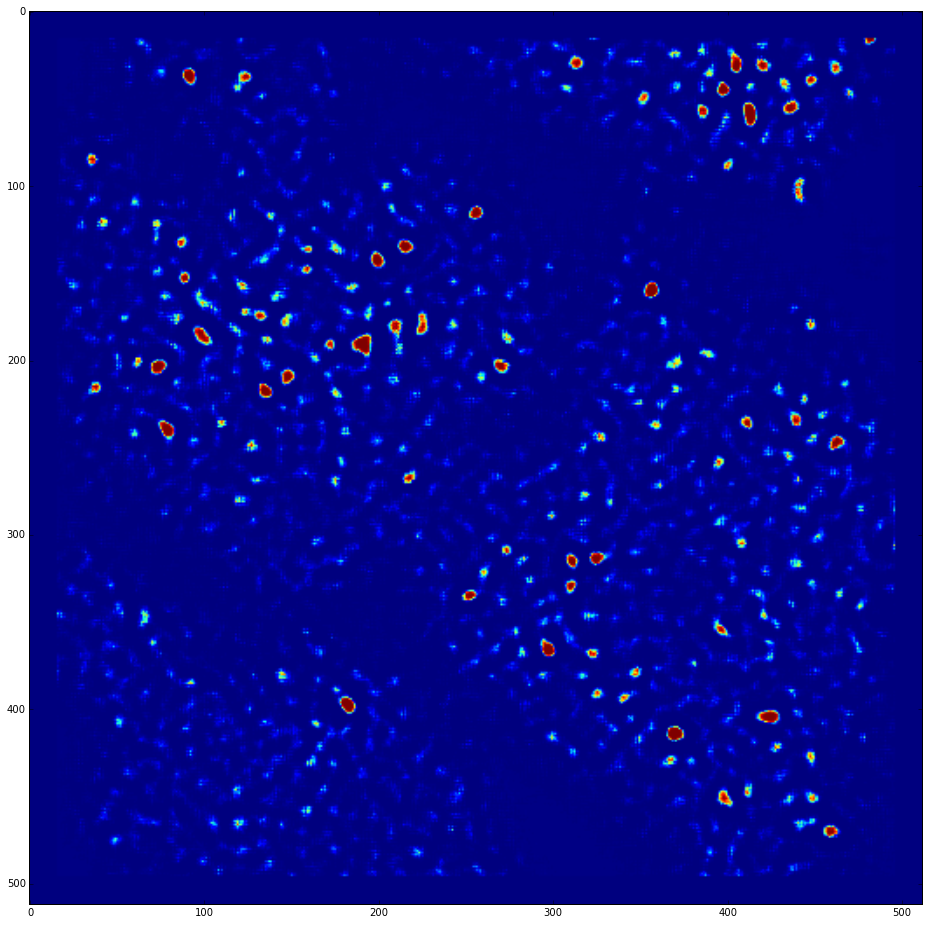

In [62]:
c = []
for i in xrange(0+r, 512-r, skip):
    for j in xrange(0+r, 512-r, skip):
        c.append([i,j])

svmMap = np.zeros((dim, dim))
for i in range(1,len(c)):
    x,y = c[i]
    svmMap[x][y] = YPred[i][0][1]

plt.rcParams['figure.figsize'] = (16, 16)
plt.imshow(svmMap)

In [70]:
s = 5
out_rois = []
roiCentres = []
for i in range(1,len(c)):
    x,y = c[i]
    if (YPred[i][0][1] > 0.9): 
        # and YPred[i+1][0][1] > 0.85 and YPred[i-1][0][1] > 0.85):
        if (M[x-s:x+s,y-s:y+s].mean() > 0.01 and y >= 16 and y <= 512-16):
            AddNewRoi(x, y, dim, s, out_rois)
            roiCentres.append(c[i])
            
len(out_rois)

966

In [71]:
new_rois = np.array(out_rois)
r1list = []
olen = []
i = 0
while (not olen or max(olen) != 1) and i < 5:
    i = i+1
    olen = []
    print "Merge", i
    working_rois = np.array(new_rois)
    l = len(working_rois)
    new_rois = []
    done = []
    for r1 in range(l):
        if (r1 not in np.array(done)):
            r1list = [r1]
            for r2 in range(l):
                if r2 != r1:
                    s = (working_rois[r1]+working_rois[r2])
                    if (float(np.count_nonzero(s)) != 0):
                        overlap=float((np.count_nonzero(s == 2))/float(np.count_nonzero(s)))
                        if overlap > 0.4:
                            r1list.append(r2)
            #print r1, len(r1list)
            olen.append(len(r1list))
            new_slice = (working_rois[r1list]).max(axis=0)
            new_rois.append(new_slice)
            done = done + r1list

filtered = []
for r in new_rois:
    if r.sum() > 100: 
        filtered.append(r)

Merge 1
Merge 2
Merge 3
Merge 4


In [72]:
%run test.py
score = Score(None, stk,rois,np.array(filtered))
print score

Total F1 Score      = 0.527777777778
F1 Score per stack  = [0.5277777777777777]
Total Precision     = 0.808510638298
Precision per stack = [0.8085106382978723]
Total Recall        = 0.39175257732
Recall per stack    = [0.3917525773195876]
Overlap Boundary Quality, all stacks = {'std recall': 0.12936841069373436, 'mean precision': 0.89715390380364657, 'std precision': 0.1003986298109411, 'mean recall': 0.78354495447071593}
Overlap Boundary Quality, per stack  = [{'std recall': 0.12936841069373436, 'mean precision': 0.89715390380364657, 'std precision': 0.1003986298109411, 'mean recall': 0.78354495447071593}]




In [84]:
%run test.py
score = Score(None, stk,rois,np.array(filtered))
print score

Total F1 Score      = 0.722408026756
F1 Score per stack  = [0.7224080267558527]
Total Precision     = 0.760563380282
Precision per stack = [0.7605633802816901]
Total Recall        = 0.687898089172
Recall per stack    = [0.6878980891719745]
Overlap Boundary Quality, all stacks = {'std recall': 0.1406970345855077, 'mean precision': 0.91816575998377636, 'std precision': 0.10622388006519909, 'mean recall': 0.74634197516486178}
Overlap Boundary Quality, per stack  = [{'std recall': 0.1406970345855077, 'mean precision': 0.91816575998377636, 'std precision': 0.10622388006519909, 'mean recall': 0.74634197516486178}]




In [ ]:
K = np.zeros((dim,dim,3))
K[:,:,0] = K[:,:,1] = K[:,:,2] = getM(stk)
#plt.imshow(sum(out_rois)>3)
K[:,:,2] = np.maximum(sum(out_rois), getM(stk))
#plt.imshow(np.array(out_rois).max(axis=0))
plt.imshow(K)
plt.imshow(np.array(filtered).max(axis = 0) + 2*rois.max(axis=0))

In [ ]:
(stk, rois) = data[10]

dim = 512
skip = 1
r = 16
XVal = []
M = getM(stk)
YPred = []
for x in xrange(0+r, dim-r, skip):
    for y in xrange(0+r, dim-r, skip):
        fd = getHogTile(M[x-r:x+r, y-r:y+r])
        XVal.append(fd)
        
for i in range(len(XVal)): 
    YPred.append(svm1.predict_proba(XVal[i]))  

c = []
r = 16
for i in xrange(0+r, 512-r, skip):
    for j in xrange(0+r, 512-r, skip):
        c.append([i,j])
        
out_rois = []
roiCentres = []
s = 5;
for i in range(1,len(c)):
    x,y = c[i]
    if (YPred[i][0][1] > 0.9 and YPred[i+1][0][1] > 0.85 and YPred[i-1][0][1] > 0.85):
        if (M[x-s:x+s,y-s:y+s].mean() > 0.01 and y >= 16 and y <= 512-16):
            AddNewRoi(x, y, dim, s, out_rois)
            roiCentres.append(c[i])

new_rois = np.array(out_rois)
r1list = []
olen = []
i = 0
while (not olen or max(olen) != 1) and i < 5:
    i = i+1
    olen = []
    print "Merge"
    working_rois = np.array(new_rois)
    l = len(working_rois)
    new_rois = []
    done = []
    for r1 in range(l):
        if (r1 not in np.array(done)):
            r1list = [r1]
            for r2 in range(l):
                if r2 != r1:
                    s = (working_rois[r1]+working_rois[r2])
                    if (float(np.count_nonzero(s)) != 0):
                        overlap=float((np.count_nonzero(s == 2))/float(np.count_nonzero(s)))
                        if overlap > 0.4:
                            r1list.append(r2)
            print r1, len(r1list)
            olen.append(len(r1list))
            new_slice = (working_rois[r1list]).max(axis=0)
            new_rois.append(new_slice)
            done = done + r1list
            
filtered = []
for r in new_rois:
    if r.sum() > 100: 
        filtered.append(r)
        
%run test.py
score = Score(None, stk,rois,np.array(filtered))
print score

In [ ]:
whos